In [2]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


character(0)

# Examen 2. Pronósticos Modelos multivariados 

### Paso 1. Aplicación de los modelos 

#### Instrucciones:

1. Descarga de YahooFinancelas series de precios de cierre de RYLD, TSLA, TM y GM en las fechas: 22-04-2019 al 31-12-2022.
2. Grafica las series.
3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.
4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.
5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos.
6. Aplica los modelos VAR o VECM según corresponda (con ambas librerías, vars y mts) y ARDL al conjunto de series. En el caso de ARDL explica el comportamiento del índice en función de los activos. En caso de elegir un modelo VAR, toma la postura de diferenciar las series para hacerlas estacionarias, esto sin importar el valor característico de las matrices phi's de un modelo vectorial. Te puedes apoyar en los tutoriales realizados durante estas semanas.
7. Realiza un análisis de impulso-respuesta sobre el modelo vectorial.
8. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debes calcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.

### Paso 2. Comparación de los modelos y selección del mejor

1. Una vez seguiste las indicaciones de la parte 1 y aplicaste los modelos vectoriales y ARDL sobre las series RYLD, TSLA, TM y GM en las fechas: 22-04-2019 al 31-12-2022:
2. Compara y sustenta qué modelo presentó un mejor desempeño de acuerdo a los criterios de selección pertinentes.
3. Genera un pronóstico de 10 días hacia adelante y una visualización del mismo.
4. Discute acerca de las ventajas, desventajas y aplicabilidad que identificaste en cada uno de los modelos para dar respuesta a tu problema de pronóstico.



#### Importación de librerías

In [3]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
library(dplyr)
library(stats)
library(MTS)
library(urca)
library(vars)
library(tsDyn)
library(tidyverse) 
library(fields)  
library(forecast)     
library(TSstudio)
library(mgcv)
library(caret)
theme_set(theme_bw())
library(devtools)
library(fpp3)
library(vars)
options(warn = - 1) 

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', exclude = 'lag') to your .Rprofile to stop           #
# dplyr from breaking base R's lag() function.                                #
#                                                                             #
# Code in packages is n

## Desarrollo

#### 1. Descarga de Yahoo Finance las series de precios de cierre de RYLD, TSLA, TM y GM en las fechas: 22-04-2019 al 31-12-2022.

In [4]:
 #Descargar la serie de Yahoo Finance

start<-format(as.Date("2019-04-22"),"%Y-%m-%d") #fecha de inicio 
end<-format(as.Date("2022-12-31"),"%Y-%m-%d") #fecha de cierre

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Eliminar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}

##Llamar el activo de interés, pueden ser varios: 
RYLD= precios("RYLD")
TSLA= precios("TSLA")
TM= precios("TM")
GM=precios ("GM")

##Llamamos por facilidad a nuestros activos:
RYLD= `RYLD`
TSLA=`TSLA`
TM=`TM`
GM=`GM`

In [5]:
## Juntamos los datos, renombramos las columnas y las visualizamos:
data<-merge.xts(`RYLD`, `TSLA`,`TM`, `GM`)%>% na.omit()
colnames(data)<-c("RYLD",  "TSLA", "TM", "GM")
dim(data)

[1] 933   4

In [6]:
length(data[,1])

[1] 933

#### 2. Grafíca las series


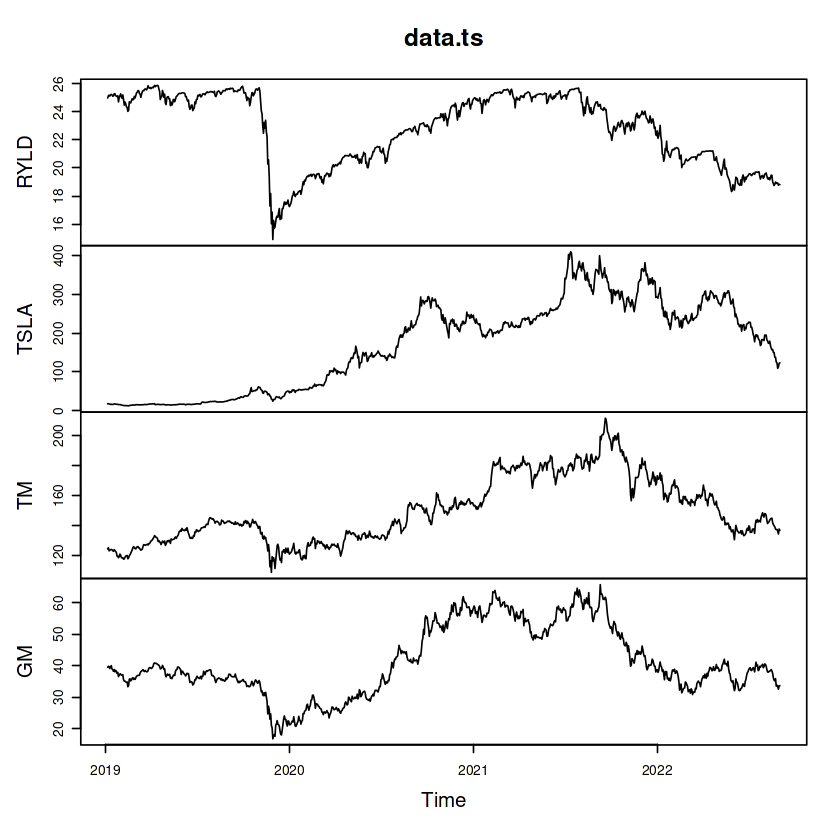

In [7]:
data.ts=ts(data, start=c(2019,4),frequency=255)
plot(data.ts)

#### 3. Formato adecuado de los datos

In [8]:

#Ya que tenemos que trabajar en formato ts
y <- ts(data$RYLD, start = c(2019,4), frequency = 252)
tsla <- ts(data$TSLA, start = c(2019,4), frequency = 252)
tm <- ts(data$TM, start = c(2019,4), frequency = 252)
gm <- ts(data$GM, start = c(2019,4), frequency = 252)

#### 4. Partir la serie en 5% de prueba y el restante de entrenamiento

In [48]:
#Partir la serie a un 5% de prueba y el restante para el entrenamiento.
h <- round(length(data[,1])*0.05, digits = 0 )
h
data_train <- data[1:(nrow(data) - h), ]
data_test<- data[(nrow(data) - h + 1):nrow(data), ]


[1] 47

In [154]:
data_test

            RYLD   TSLA     TM    GM
2022-10-25 19.35 222.42 137.07 37.01
2022-10-26 19.41 224.64 137.93 37.86
2022-10-27 19.45 225.09 136.47 38.16
2022-10-28 19.56 228.52 139.52 38.85
2022-10-31 19.58 227.54 138.81 39.25
2022-11-01 19.58 227.82 135.16 39.35
2022-11-02 19.49 214.98 135.39 38.52
2022-11-03 19.46 215.31 135.25 38.51
2022-11-04 19.55 207.47 137.35 39.00
2022-11-07 19.61 197.08 137.26 39.39
2022-11-08 19.63 191.30 137.50 39.05
2022-11-09 19.55 177.59 134.53 38.06
2022-11-10 19.70 190.72 140.52 39.74
2022-11-11 19.71 195.97 143.26 41.12
2022-11-14 19.70 190.95 142.12 39.93
2022-11-15 19.70 194.42 143.75 40.24
2022-11-16 19.71 186.92 142.12 38.47
2022-11-17 19.73 183.17 142.93 38.64
2022-11-18 19.47 180.19 143.19 39.77
2022-11-21 19.21 167.87 142.16 39.52
2022-11-22 19.37 169.91 145.33 39.97
2022-11-23 19.43 183.20 146.71 40.11
2022-11-25 19.46 182.86 148.27 40.46
2022-11-28 19.27 182.92 146.51 39.38
2022-11-29 19.34 180.83 145.40 39.75
2022-11-30 19.56 194.70 147.69 40.56
2

#### 5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos.

## Modelo VAR o VECM

Con el objetivo de conocer si se debe implementar un modelo VAR o VECM se verá si las series presenta cointegradas

In [10]:
#Identificamos el nivel regresivo, mediante la función VARselect
nivelka=VARselect(data_train, lag.max = 7, type = "const")
nivelka$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      1      1      3

Ya que los resultados de la prueba de criterio de información muestran que el orden regresivo puede ser 1 o 3, elegiremos el modelo con un orden de 3. 

In [11]:
# Aplicamos la prueba de Johansen para la identificación de relaciones lineales entre las series, lo que nos indica la condición de cointegración.
johatest=ca.jo(data.ts, type = "trace", K=3, ecdet ="none", spec = "longrun") #
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.025178838 0.013551622 0.005454097 0.001665807

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 3 |  1.55  6.50  8.18 11.65
r <= 2 |  6.64 15.66 17.95 23.52
r <= 1 | 19.33 28.71 31.52 37.22
r = 0  | 43.04 45.23 48.28 55.43

Eigenvectors, normalised to first column:
(These are the cointegration relations)

            RYLD.l3     TSLA.l3        TM.l3      GM.l3
RYLD.l3  1.00000000  1.00000000  1.000000000 1.00000000
TSLA.l3  0.04047053  0.01420505 -0.006160056 0.07517971
TM.l3   -0.19656578  0.11367107 -0.016571013 0.04088028
GM.l3   -0.13677494 -0.47698175 -0.007522554 0.33936225

Weights W:
(This is the loading matrix)

           RYLD.l3      TSLA.l3        TM.l3         GM.l3
RYLD.d -0.00167326 -0.005669915 -0.003600594 -0.0005984274
TSLA.d -0.15022102  0.046282162  0.103842662 -0.0217639916


Las series no están cointegradas, por lo que debemos de proceder con el modelo VAR, y además revisar las condiciones de estacionaridad para proceder con la diferenciación y el modelo VAR. 

Según el enunciado del problema se debe aplicar una diferenciación para el modelo VAR.

In [12]:
#diferenciar este sistema es simplemente tomar cada serie estabilizada de la tendencia, aplicar la función diff() y posteriormente, unir las serie
y=diff(data_train[,1],1)
tsla=diff((data_train[,2]),1)
tm=diff(data_train[,3],1)
gm=diff(data_train[,4],1)
z=cbind.data.frame(y,tsla,tm,gm)%>% na.omit()
head(z)
length(z[,1])

,RYLD,TSLA,TM,GM
,<dbl>,<dbl>,<dbl>,<dbl>
2019-04-23,0.16199875,0.07666588,0.7799988,0.3300018
2019-04-24,0.03199959,-0.34933281,-2.0600052,-0.1100006
2019-04-25,-0.05900002,-0.73533249,0.3100052,-0.6100006
2019-04-26,0.09500122,-0.83266735,0.4300003,0.5699997
2019-04-29,0.02499962,0.42199993,0.1899948,0.3299980
2019-04-30,-0.03899956,-0.18533230,-0.2099991,-1.0599976


[1] 885

### Modelación con VARS

In [13]:
#Selección del orden regresivo
# En la librería de VAR, la función que permite identificar el orden regresivo es la función de VARselect(). Se elige el máximo de rezagos de lag.max=7.
nivelk=VARselect(z, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2

In [14]:
#Podemos volver a llamar la librería de vars y aplicar el regresión habiendo encontrado que p=2
m0=vars::VAR(z,p=2)
summary(m0)


VAR Estimation Results:
Endogenous variables: RYLD, TSLA, TM, GM 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = z, p = 2)


Estimation results for equation RYLD: 
RYLD = RYLD.l1 + TSLA.l1 + TM.l1 + GM.l1 + RYLD.l2 + TSLA.l2 + TM.l2 + GM.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
RYLD.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
TSLA.l1  0.0003732  0.0011952   0.312  0.75490    
TM.l1   -0.0017988  0.0046631  -0.386  0.69977    
GM.l1    0.0152832  0.0104306   1.465  0.14322    
RYLD.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
TSLA.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
TM.l2   -0.0001906  0.0046566  -0.041  0.96736    
GM.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const   -0.0054134  0.0088864  -0.609  0.54256    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard erro

### Modelación con MTS

In [15]:
#Selección del orden regresivo
# En la librería de MTS, la función que permite la identificación del nivel regresivo es la de VARorder().
VARorder(z) 

selected order: aic =  2 
selected order: bic =  0 
selected order: hq =  2 
Summary table:  
       p    AIC    BIC     HQ    M(p) p-value
 [1,]  0 2.5661 2.5661 2.5661  0.0000  0.0000
 [2,]  1 2.5449 2.6314 2.5780 49.7083  0.0000
 [3,]  2 2.4953 2.6684 2.5615 73.9426  0.0000
 [4,]  3 2.5222 2.7818 2.6215  7.9571  0.9501
 [5,]  4 2.5303 2.8764 2.6626 24.0192  0.0891
 [6,]  5 2.5446 2.9772 2.7100 18.5593  0.2922
 [7,]  6 2.5595 3.0786 2.7580 18.0183  0.3228
 [8,]  7 2.5537 3.1593 2.7852 35.3461  0.0036
 [9,]  8 2.5613 3.2535 2.8259 23.9211  0.0912
[10,]  9 2.5573 3.3360 2.8550 33.5402  0.0063
[11,] 10 2.5694 3.4346 2.9002 19.9465  0.2226
[12,] 11 2.5765 3.5282 2.9403 24.0472  0.0885
[13,] 12 2.5973 3.6355 2.9942 12.6425  0.6987
[14,] 13 2.6195 3.7443 3.0495 11.3889  0.7849


In [16]:
#Modelado
#Ahora, aplicamos la función de VAR, para generar el modelo de regresión:
m1=MTS::VAR(z,2)

Constant term: 
Estimates:  -0.005413425 0.2545003 0.007388606 -0.001985235 
Std.Error:  0.008886438 0.2742414 0.07765216 0.03683012 
AR coefficient matrix 
AR( 1 )-matrix 
        [,1]      [,2]    [,3]     [,4]
[1,] -0.1405  0.000373 -0.0018  0.01528
[2,]  1.2525 -0.043873 -0.0131 -0.35200
[3,] -1.0907  0.014009  0.0122  0.09280
[4,] -0.0555  0.009925 -0.0102 -0.00975
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0427 0.00120 0.00466 0.0104
[2,] 1.3184 0.03688 0.14391 0.3219
[3,] 0.3733 0.01044 0.04075 0.0911
[4,] 0.1771 0.00495 0.01933 0.0432
AR( 2 )-matrix 
      [,1]     [,2]      [,3]    [,4]
[1,] 0.286 -0.00234 -0.000191 -0.0206
[2,] 2.394 -0.01228 -0.016173 -0.0696
[3,] 0.243 -0.00693  0.012395  0.1269
[4,] 0.442 -0.00867 -0.032857 -0.0179
standard error 
       [,1]    [,2]    [,3]   [,4]
[1,] 0.0429 0.00120 0.00466 0.0104
[2,] 1.3230 0.03689 0.14371 0.3213
[3,] 0.3746 0.01045 0.04069 0.0910
[4,] 0.1777 0.00495 0.01930 0.0431
  
Residuals cov-mtx: 
           [,1] 

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]   1.000     0.193 -20.000     1.00
 [2,]   2.000     0.890  -4.000     1.00
 [3,]   3.000     6.124  12.000     1.00
 [4,]   4.000    32.267  28.000     0.26
 [5,]   5.000    49.949  44.000     0.25
 [6,]   6.000    66.022  60.000     0.28
 [7,]   7.000    99.954  76.000     0.03
 [8,]   8.000   126.774  92.000     0.01
 [9,]   9.000   167.835 108.000     0.00
[10,]  10.000   183.934 124.000     0.00
[11,]  11.000   203.825 140.000     0.00
[12,]  12.000   215.183 156.000     0.00
[13,]  13.000   226.861 172.000     0.00
[14,]  14.000   250.189 188.000     0.00
[15,]  15.000   274.746 204.000     0.00
[16,]  16.000   292.363 220.000     0.00
[17,]  17.000   315.377 236.000     0.00
[18,]  18.000   337.159 252.000     0.00
[19,]  19.000   379.438 268.000     0.00
[20,]  20.000   388.513 284.000     0.00
[21,]  21.000   402.650 300.000     0.00
[22,]  22.000   415.505 316.000     0.00
[23,]  23.000   434.643 332.000  

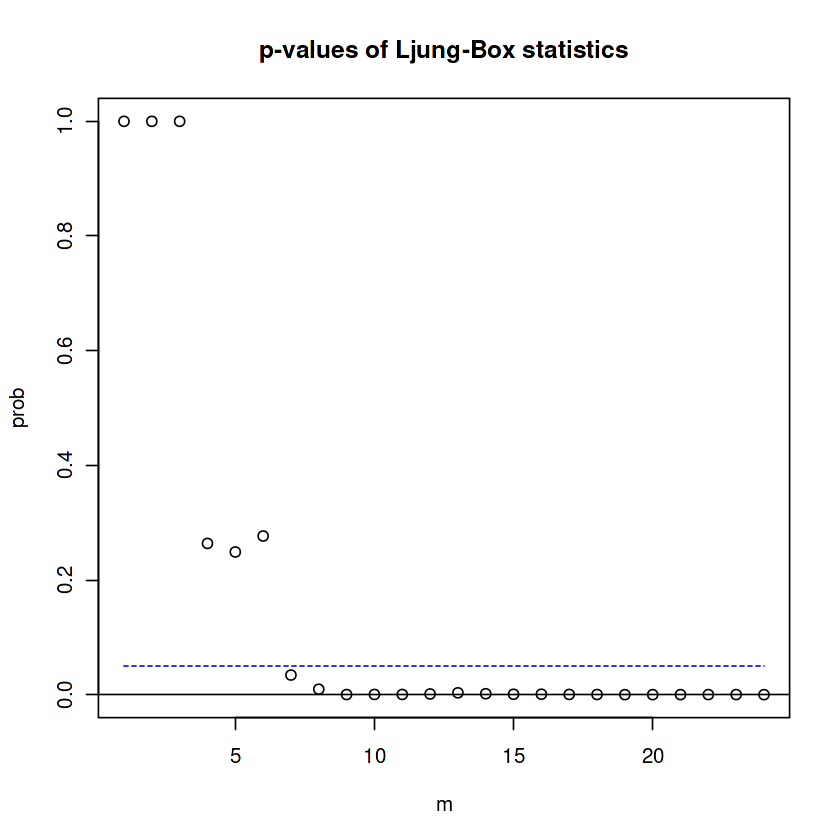

In [17]:
#Separemos primero los residuales del modelo de regresión y apliquemos la función de mq() para la revisión de la calidad del modelo.
#Indicamos los grados de libertad del modelo, que son 36 (2 matrices autorregresivas de 16 coeficientes, cada uno, mas 4 ordenadas).
resi=m1$residuals
mq(resi, adj=36)

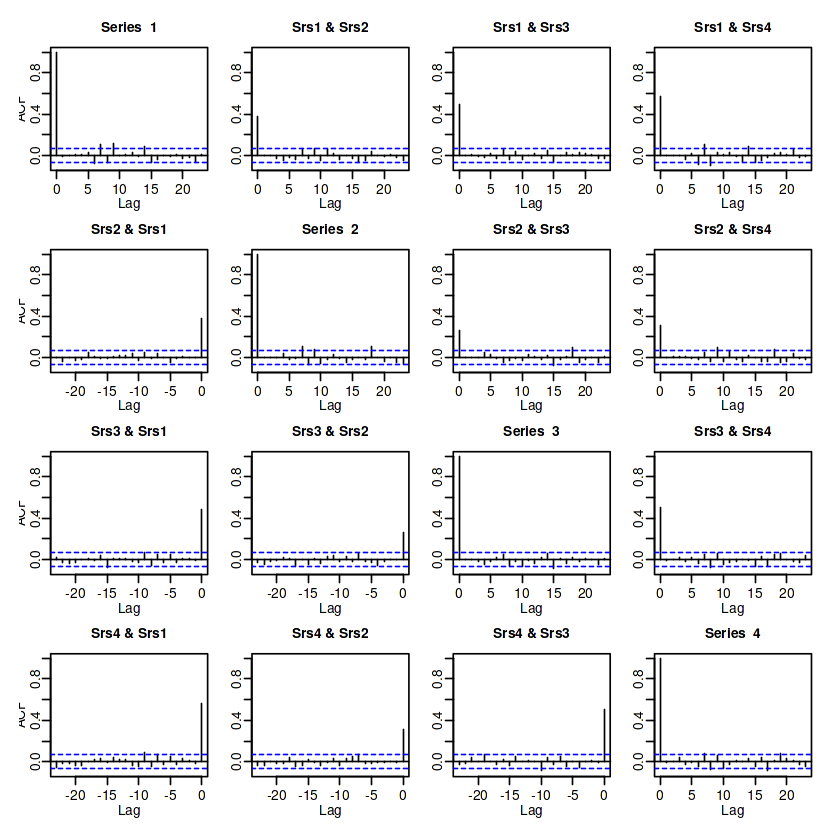

In [18]:
#Podemos igualmente visualizar los rezagos de los residuales, en búsuqueda de rezagos no capturados por el modelo.
acf(resi) 

In [19]:
#Simplificación del modelo
# Aplicamos para la simplificación, la función refVAR().
m2=refVAR(m1,thres = 1.96)

Constant term: 
Estimates:  0 0 0 0 
Std.Error:  0 0 0 0 
AR coefficient matrix 
AR( 1 )-matrix 
       [,1] [,2] [,3] [,4]
[1,] -0.110    0    0    0
[2,]  0.000    0    0    0
[3,] -0.712    0    0    0
[4,]  0.000    0    0    0
standard error 
       [,1] [,2] [,3] [,4]
[1,] 0.0329    0    0    0
[2,] 0.0000    0    0    0
[3,] 0.2832    0    0    0
[4,] 0.0000    0    0    0
AR( 2 )-matrix 
      [,1]     [,2]    [,3]    [,4]
[1,] 0.272  0.00000  0.0000 -0.0243
[2,] 0.000  0.00000  0.0000  0.0000
[3,] 0.000  0.00000  0.0000  0.1554
[4,] 0.439 -0.00962 -0.0361  0.0000
standard error 
       [,1]   [,2]   [,3]    [,4]
[1,] 0.0396 0.0000 0.0000 0.00979
[2,] 0.0000 0.0000 0.0000 0.00000
[3,] 0.0000 0.0000 0.0000 0.07076
[4,] 0.1612 0.0049 0.0183 0.00000
  
Residuals cov-mtx: 
                      resi                    
     0.06916046  0.7964633 0.2955452 0.1612436
resi 0.79646333 65.9615077 4.8661707 2.6771854
     0.29554517  4.8661707 5.2722566 1.2711235
     0.16124361  2.67718

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]   1.0      17.8     2.0     1.00
 [2,]   2.0      29.5    18.0     0.04
 [3,]   3.0      35.0    34.0     0.42
 [4,]   4.0      61.1    50.0     0.14
 [5,]   5.0      76.7    66.0     0.17
 [6,]   6.0      92.3    82.0     0.21
 [7,]   7.0     127.5    98.0     0.02
 [8,]   8.0     157.3   114.0     0.00
 [9,]   9.0     199.8   130.0     0.00
[10,]  10.0     216.8   146.0     0.00
[11,]  11.0     236.4   162.0     0.00
[12,]  12.0     248.0   178.0     0.00
[13,]  13.0     260.6   194.0     0.00
[14,]  14.0     284.8   210.0     0.00
[15,]  15.0     309.6   226.0     0.00
[16,]  16.0     327.2   242.0     0.00
[17,]  17.0     352.2   258.0     0.00
[18,]  18.0     373.5   274.0     0.00
[19,]  19.0     417.2   290.0     0.00
[20,]  20.0     425.9   306.0     0.00
[21,]  21.0     439.9   322.0     0.00
[22,]  22.0     452.4   338.0     0.00
[23,]  23.0     472.4   354.0     0.00
[24,]  24.0     507.7   370.0     0.00


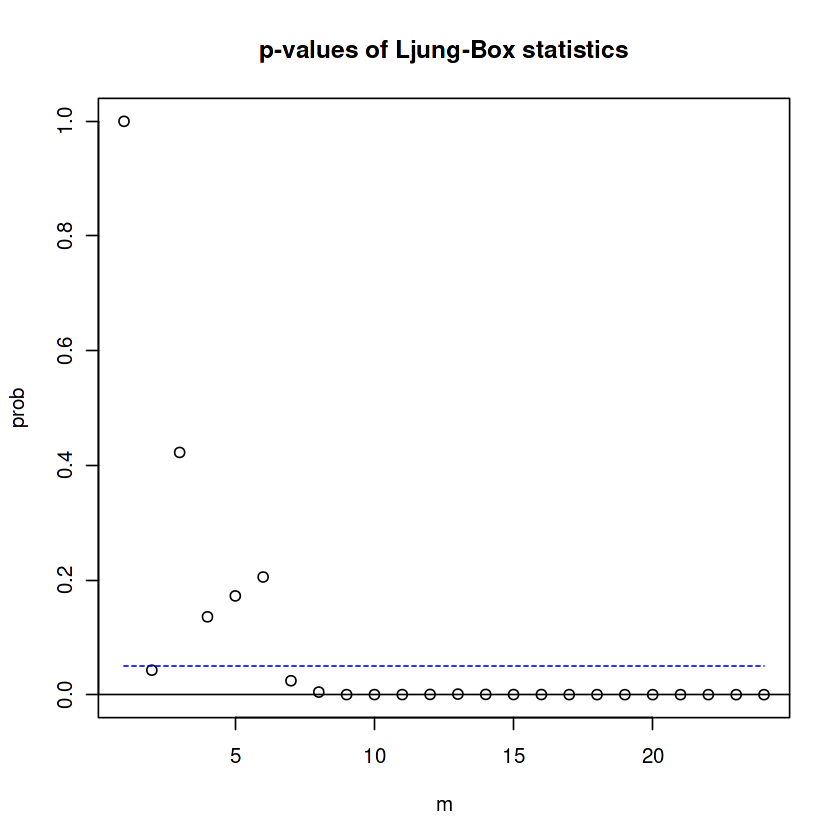

In [20]:
# Separamos nuevamente los residuales del modelo refinado y aplicamos función de revisión mediante función mq()
resi2=m2$residuals
mq(resi2, adj=14)

In [21]:
# Aplicamos la función de diagnóstico al modelo terminal, esto, para permitir observar si existe una dependencia inmediata en las series.
MTSdiag(m2, adj=13) #Recordar que el modelo se reduce a 12 parámetros.

[1] "Covariance matrix:"
       RYLD   TSLA    TM    GM
RYLD 0.0692  0.799 0.296 0.161
TSLA 0.7987 65.988 4.870 2.680
TM   0.2959  4.870 5.278 1.273
GM   0.1614  2.680 1.273 1.187
CCM at lag:  0 
      [,1]  [,2]  [,3]  [,4]
[1,] 1.000 0.374 0.490 0.563
[2,] 0.374 1.000 0.261 0.303
[3,] 0.490 0.261 1.000 0.508
[4,] 0.563 0.303 0.508 1.000
Simplified matrix: 
CCM at lag:  1 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  2 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  3 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  4 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  5 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag:  6 
- . . - 
. . . . 
. . . . 
. . . . 
CCM at lag:  7 
+ + . + 
. + . . 
. . . . 
+ + . + 
CCM at lag:  8 
. . . - 
. - . . 
. . . - 
. . . - 
CCM at lag:  9 
+ + . . 
. + . + 
. . . . 
+ . . . 
CCM at lag:  10 
. . . . 
. . . . 
. . - . 
. . - . 
CCM at lag:  11 
. . . . 
. . . + 
. . . . 
. . . . 
CCM at lag:  12 
. . . . 
. . . . 
. . . . 
. . . . 
CCM at lag: 

Podemos observar que no existen correlaciones instantáneas entre las series. Esto, ya que los p-valores de la matriz de CCM lag 0, son mayores a la significancia del 5%. 

#### 6. Análisis impulso respuesta

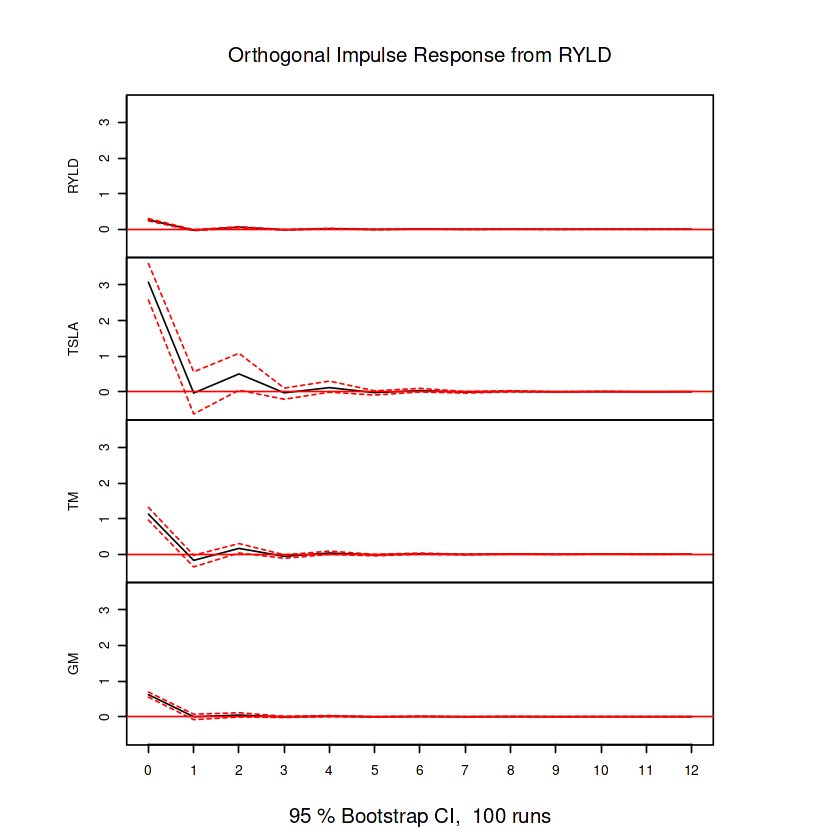

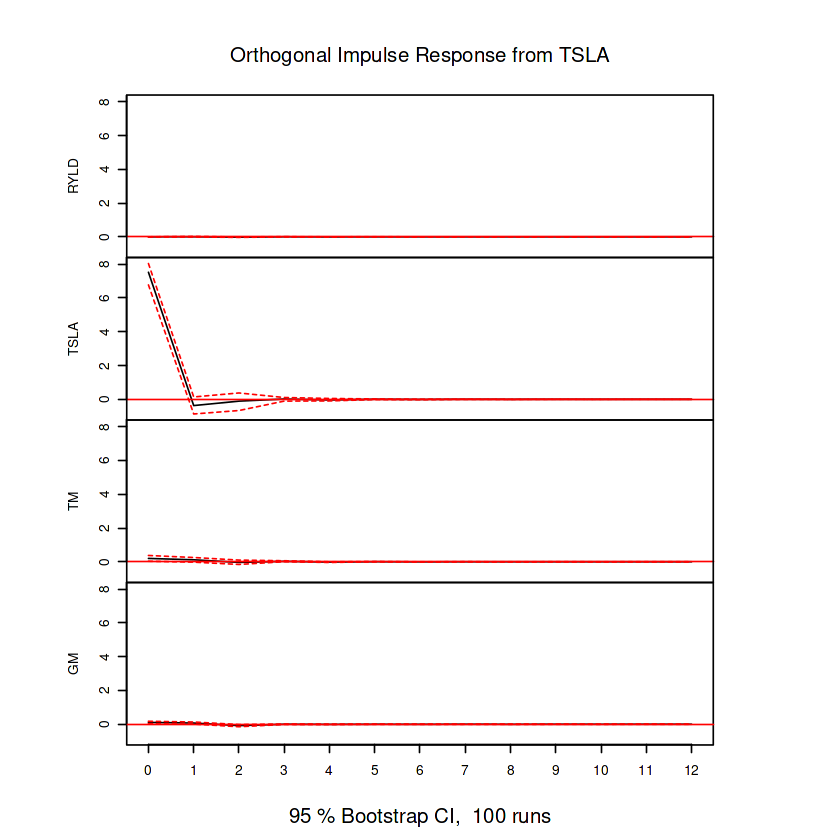

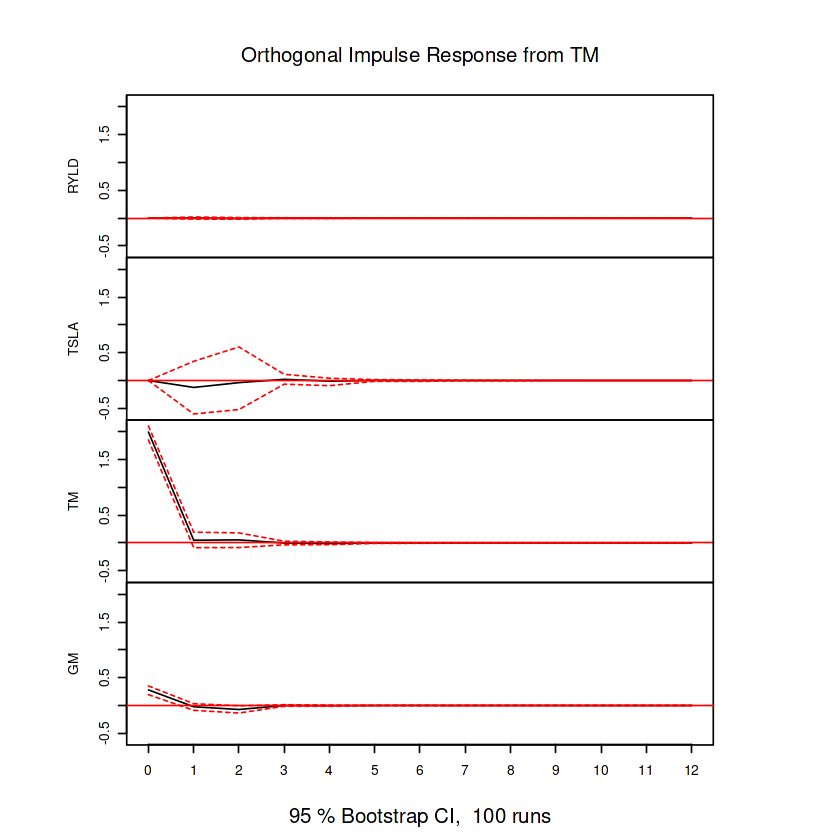

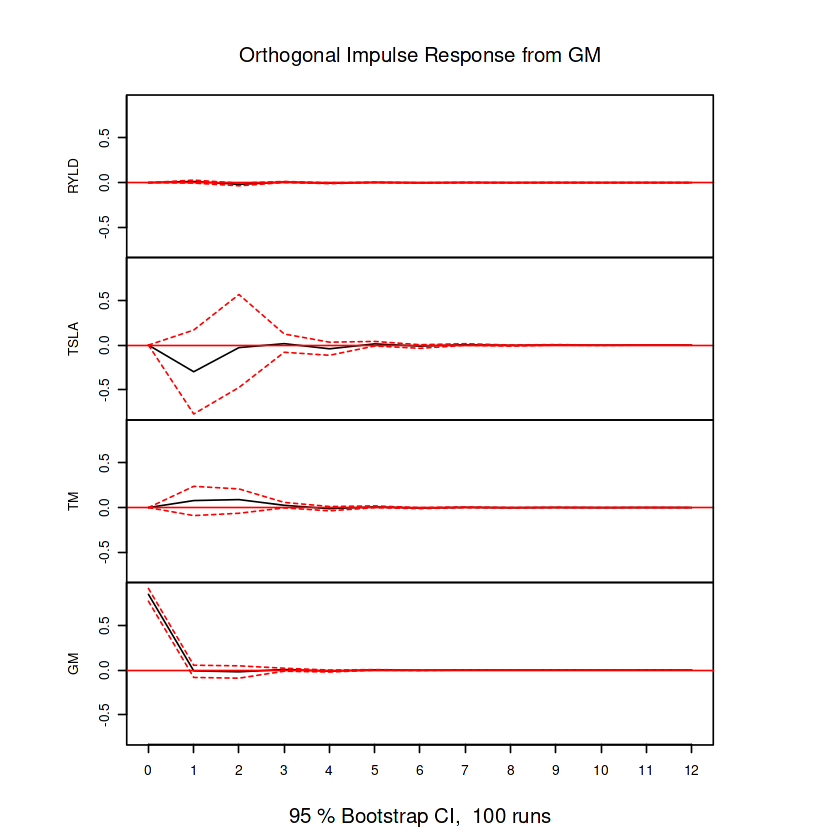

In [22]:
# La función de impulso respuesta se lleva a cabo mediante la librería de vars. La función es la irf(). Apliquemos la función al primer modelo.
m1irf = irf(m0, n.ahead = 12, boot = TRUE)
plot(m1irf) 

#### Predicción a 47 días

In [221]:
#Apliquemos la predicción al segundo modelo. Esto, ya que la función VARpredict pertenece a la librería de MTS.
#Igualmente, podemos observar que se generan los resultados de pronóstico de cada una de las series y las ecuaciones de estimación de las series.
predm2=VARpred(m2, 47)  #Podemos generar un pronóstico a 12 días adelante.
var_est3 <- vars:: VAR(z,p = 2)
summary(var_est3)

orig  885 
Forecasts at origin:  885 
       RYLD TSLA         TM         GM
  0.0696144    0  0.3564146  0.0570355
 -0.0686837    0  0.0623180 -0.0748727
  0.0251124    0  0.0577850  0.0176518
 -0.0196497    0 -0.0295231 -0.0323703
  0.0085678    0  0.0167391  0.0089248
 -0.0055077    0 -0.0111334 -0.0075502
  0.0027216    0  0.0053100  0.0031524
 -0.0016158    0 -0.0031119 -0.0020130
  0.0008422    0  0.0016408  0.0010016
 -0.0004837    0 -0.0009127 -0.0005961
Standard Errors of predictions:  
              resi            
 [1,] 0.2630 8.122 2.296 1.089
 [2,] 0.2646 8.122 2.304 1.089
 [3,] 0.2721 8.122 2.311 1.095
 [4,] 0.2725 8.122 2.311 1.095
 [5,] 0.2731 8.122 2.311 1.095
 [6,] 0.2732 8.122 2.312 1.095
 [7,] 0.2732 8.122 2.312 1.095
 [8,] 0.2732 8.122 2.312 1.095
 [9,] 0.2732 8.122 2.312 1.095
[10,] 0.2732 8.122 2.312 1.095
Root mean square errors of predictions:  
              resi            
 [1,] 0.2643 8.163 2.308 1.094
 [2,] 0.2785 8.122 2.372 1.089
 [3,] 0.3335 8.122 2.37


VAR Estimation Results:
Endogenous variables: RYLD, TSLA, TM, GM 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = z, p = 2)


Estimation results for equation RYLD: 
RYLD = RYLD.l1 + TSLA.l1 + TM.l1 + GM.l1 + RYLD.l2 + TSLA.l2 + TM.l2 + GM.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
RYLD.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
TSLA.l1  0.0003732  0.0011952   0.312  0.75490    
TM.l1   -0.0017988  0.0046631  -0.386  0.69977    
GM.l1    0.0152832  0.0104306   1.465  0.14322    
RYLD.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
TSLA.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
TM.l2   -0.0001906  0.0046566  -0.041  0.96736    
GM.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const   -0.0054134  0.0088864  -0.609  0.54256    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard erro

#### Recuperación del nivel en el pronóstico

Ya que los resultados de pronóstico están en unidades diferenciadas de las series, un paso ideal es la aplicación de una función que permita la recuperación del nivel. A continuación, una propuesta para tal recuperación.

In [193]:
#Especificamos el horizonte de pronóstico.
nhor=47 #pasos en el pronóstico.
nr_lev <- nrow(data_train)
mr_lev= as.matrix(data_train)
tail(mr_lev)
str(mr_lev)

,RYLD,TSLA,TM,GM
2022-10-17,19.33,219.35,136.16,33.57
2022-10-18,19.50,220.19,134.26,34.25
2022-10-19,19.26,222.04,132.97,33.63
2022-10-20,19.01,207.28,133.24,33.44
2022-10-21,19.34,214.44,133.76,35.00
2022-10-24,19.18,211.25,134.74,35.72


 num [1:886, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:886] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [194]:
nr_lev

[1] 886

In [195]:
# Generamos primeramente una estructura de datos con NAs que se poblarán con los valores de pronóstico, que se irán sumando acumuladamente.
m.varf_lev_ft <- rbind(mr_lev[,1:4], matrix(NA, nhor,4 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

,RYLD,TSLA,TM,GM
2019-04-22,24.995,17.51667,124.16,39.50
2019-04-23,25.157,17.59333,124.94,39.83
2019-04-24,25.189,17.24400,122.88,39.72
2019-04-25,25.130,16.50867,123.19,39.11
2019-04-26,25.225,15.67600,123.62,39.68
2019-04-29,25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA


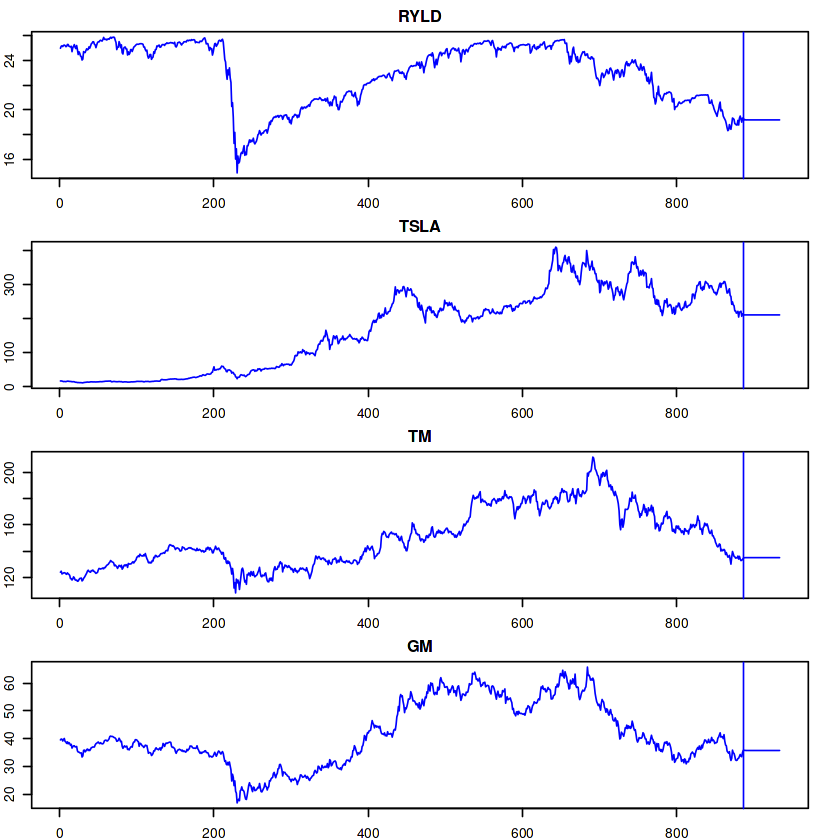

In [196]:
#En la función de recuperación, especificamos los valores que se consideran del modelo seleccionado. Generamos igualmente una visualización del resultado.
m.ft_df <- predm2$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}
str.main=c("RYLD", "TSLA", "TM","GM")
par(mfrow=c(4,1), mar=c(2,2,2,2))
for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="blue")
}

In [215]:
m.ft_df <- predm2$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}
pred=m.varf_lev_ft[887:933,1]
pred

19.24961 19.18093 19.20604 19.18639 19.19496 19.18945 19.19218 19.19056 
                                                                        
19.19140 19.19092 19.19118 19.19103 19.19111 19.19107 19.19109 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                                        
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 
                                                               
19.19108 19.19108 19.19108 19.19108 19.19108 19.19108 19.19108

In [219]:
library(Metrics)
RMSE1<-rmse(data_test$RYLD,pred)
RMSE1
MAE1<-mae(data_test$RYLD, pred)
MAE1

[1] 0.3298093

[1] 0.2968814

### Predicción a 10 días

In [222]:
#Apliquemos la predicción al segundo modelo. Esto, ya que la función VARpredict pertenece a la librería de MTS.
#Igualmente, podemos observar que se generan los resultados de pronóstico de cada una de las series y las ecuaciones de estimación de las series.
predm3=VARpred(m2, 10)  #Podemos generar un pronóstico a 12 días adelante.
var_est4 <- vars:: VAR(z,p = 2)
summary(var_est4)

orig  885 
Forecasts at origin:  885 
       RYLD TSLA         TM         GM
  0.0696144    0  0.3564146  0.0570355
 -0.0686837    0  0.0623180 -0.0748727
  0.0251124    0  0.0577850  0.0176518
 -0.0196497    0 -0.0295231 -0.0323703
  0.0085678    0  0.0167391  0.0089248
 -0.0055077    0 -0.0111334 -0.0075502
  0.0027216    0  0.0053100  0.0031524
 -0.0016158    0 -0.0031119 -0.0020130
  0.0008422    0  0.0016408  0.0010016
 -0.0004837    0 -0.0009127 -0.0005961
Standard Errors of predictions:  
              resi            
 [1,] 0.2630 8.122 2.296 1.089
 [2,] 0.2646 8.122 2.304 1.089
 [3,] 0.2721 8.122 2.311 1.095
 [4,] 0.2725 8.122 2.311 1.095
 [5,] 0.2731 8.122 2.311 1.095
 [6,] 0.2732 8.122 2.312 1.095
 [7,] 0.2732 8.122 2.312 1.095
 [8,] 0.2732 8.122 2.312 1.095
 [9,] 0.2732 8.122 2.312 1.095
[10,] 0.2732 8.122 2.312 1.095
Root mean square errors of predictions:  
              resi            
 [1,] 0.2643 8.163 2.308 1.094
 [2,] 0.2785 8.122 2.372 1.089
 [3,] 0.3335 8.122 2.37


VAR Estimation Results:
Endogenous variables: RYLD, TSLA, TM, GM 
Deterministic variables: const 
Sample size: 883 
Log Likelihood: -6062.921 
Roots of the characteristic polynomial:
0.5707 0.4178 0.2799 0.2799 0.2761 0.2761 0.1395 0.09844
Call:
vars::VAR(y = z, p = 2)


Estimation results for equation RYLD: 
RYLD = RYLD.l1 + TSLA.l1 + TM.l1 + GM.l1 + RYLD.l2 + TSLA.l2 + TM.l2 + GM.l2 + const 

          Estimate Std. Error t value Pr(>|t|)    
RYLD.l1 -0.1404907  0.0427211  -3.289  0.00105 ** 
TSLA.l1  0.0003732  0.0011952   0.312  0.75490    
TM.l1   -0.0017988  0.0046631  -0.386  0.69977    
GM.l1    0.0152832  0.0104306   1.465  0.14322    
RYLD.l2  0.2856285  0.0428700   6.663 4.75e-11 ***
TSLA.l2 -0.0023379  0.0011954  -1.956  0.05081 .  
TM.l2   -0.0001906  0.0046566  -0.041  0.96736    
GM.l2   -0.0206117  0.0104105  -1.980  0.04803 *  
const   -0.0054134  0.0088864  -0.609  0.54256    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard erro

In [223]:
#Especificamos el horizonte de pronóstico.
nhor=10 #pasos en el pronóstico.
nr_lev <- nrow(data_train)
mr_lev= as.matrix(data_train)
tail(mr_lev)
str(mr_lev)

,RYLD,TSLA,TM,GM
2022-10-17,19.33,219.35,136.16,33.57
2022-10-18,19.50,220.19,134.26,34.25
2022-10-19,19.26,222.04,132.97,33.63
2022-10-20,19.01,207.28,133.24,33.44
2022-10-21,19.34,214.44,133.76,35.00
2022-10-24,19.18,211.25,134.74,35.72


 num [1:886, 1:4] 25 25.2 25.2 25.1 25.2 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:886] "2019-04-22" "2019-04-23" "2019-04-24" "2019-04-25" ...
  ..$ : chr [1:4] "RYLD" "TSLA" "TM" "GM"


In [224]:
# Generamos primeramente una estructura de datos con NAs que se poblarán con los valores de pronóstico, que se irán sumando acumuladamente.
m.varf_lev_ft <- rbind(mr_lev[,1:4], matrix(NA, nhor,4 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

,RYLD,TSLA,TM,GM
2019-04-22,24.995,17.51667,124.16,39.50
2019-04-23,25.157,17.59333,124.94,39.83
2019-04-24,25.189,17.24400,122.88,39.72
2019-04-25,25.130,16.50867,123.19,39.11
2019-04-26,25.225,15.67600,123.62,39.68
2019-04-29,25.250,16.09800,123.81,40.01


,RYLD,TSLA,TM,GM
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA
,NA,NA,NA,NA


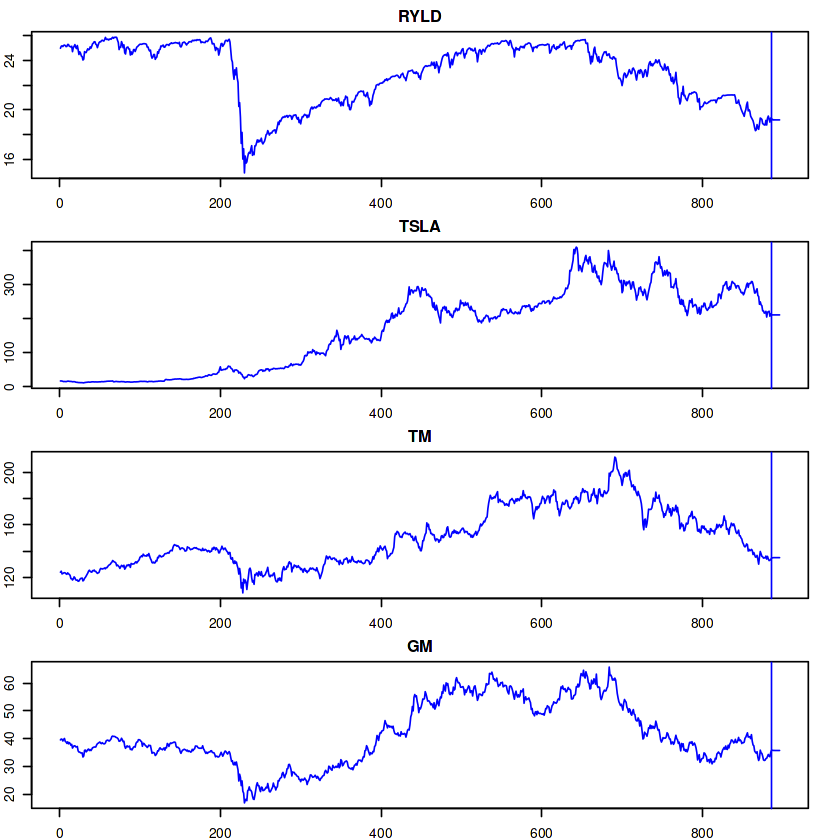

In [226]:
#En la función de recuperación, especificamos los valores que se consideran del modelo seleccionado. Generamos igualmente una visualización del resultado.
m.ft_df <- predm3$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}
str.main=c("RYLD", "TSLA", "TM","GM")
par(mfrow=c(4,1), mar=c(2,2,2,2))
for(i in 1:4) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="blue")
}

### Modelado ARDL

In [229]:
# Actualizamos la versión de R en Kaggle, así como algunas versiones de depaendencias de la paquetería ARDL. Este proceso es tardado.
#install.packages("CCA")
devtools::install_version("pbkrtest", version = "0.5.1")

knitr (1.42 -> 1.43) [CRAN]


Installing 1 packages: knitr

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [230]:
#install.packages("devtools")
devtools::install_github("Natsiopoulos/ARDL")
library(ARDL)

car   (NA -> 3.1-2) [CRAN]
dynlm (NA -> 0.3-6) [CRAN]


Skipping 1 packages not available: pbkrtest

Installing 2 packages: car, dynlm

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/Rtmpd3gpqK/remotes226dfa9dc4/Natsiopoulos-ARDL-5ae0892/DESCRIPTION’ (340ms)
─  preparing ‘ARDL’:
✔  checking DESCRIPTION meta-information
─  installing the package to process help pages
─  saving partial Rd database (6.3s)
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘ARDL_0.2.3.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

To cite the ARDL package in publications:

Use this reference to refer to the validity of the ARDL package.

  Natsiopoulos, Kleanthis, and Tzeremes, Nickolaos G. (2022). ARDL
  bounds test for cointegration: Replicating the Pesaran et al. (2001)
  results for the UK earnings equation using R. Journal of Applied
  Econometrics, 37(5), 1079-1090. https://doi.org/10.1002/jae.2919

Use this reference to cite this specific version of the ARDL package.

  Kleanthis Natsiopoulos and Nickolaos Tzeremes (2023). ARDL: ARDL, ECM
  and Bounds-Test for Cointegration. R package version 0.2.3.
  https://CRAN.R-project.org/package=ARDL



In [231]:
library(ARDL)

In [232]:
# Comprobemos que las series no son estacionarias. 
library(fUnitRoots)
adfTest(y)
adfTest(tsla)
adfTest(tm)
adfTest(gm)


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -18.0207
  P VALUE:
    0.01 

Description:
 Sun May 28 16:37:23 2023 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -21.2048
  P VALUE:
    0.01 

Description:
 Sun May 28 16:37:23 2023 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -20.0163
  P VALUE:
    0.01 

Description:
 Sun May 28 16:37:23 2023 by user: 


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 1
  STATISTIC:
    Dickey-Fuller: -21.3411
  P VALUE:
    0.01 

Description:
 Sun May 28 16:37:23 2023 by user: 

Series estacionarias

### Construcción del Modelo ARDL

In [237]:
data_train2=as.data.frame(data_train)
head(data_train2)

,RYLD,TSLA,TM,GM
,<dbl>,<dbl>,<dbl>,<dbl>
2019-04-22,24.995,17.51667,124.16,39.50
2019-04-23,25.157,17.59333,124.94,39.83
2019-04-24,25.189,17.24400,122.88,39.72
2019-04-25,25.130,16.50867,123.19,39.11
2019-04-26,25.225,15.67600,123.62,39.68
2019-04-29,25.250,16.09800,123.81,40.01


In [238]:
#Se realiza una búsqueda tipo grid search:
#Selección automatica:
models <- auto_ardl(RYLD ~ TSLA + TM + GM, data = data_train2, max_order = 6)

In [239]:
#Revisemos el top 20 de los mejores modelos según su critrio de información de Akaike
models$top_orders

RYLD,TSLA,TM,GM,AIC
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,1,1,3,-307.4130
3,1,2,3,-305.8611
3,2,1,3,-305.5586
3,1,1,4,-304.8608
4,1,1,3,-304.0696
3,2,2,3,-303.9719
4,1,1,4,-303.0162
4,1,2,3,-302.5227
4,2,1,3,-302.2173


In [240]:
#Procedemos a construir el modelo de regresión con la mejor combinación.
mod1 <- ardl(RYLD ~ TSLA + TM + GM, data = data_train2, order = c(3,1,1,3))
summary(mod1)


Time series regression with "ts" data:
Start = 4, End = 886

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67649 -0.10110  0.00956  0.11214  0.73684 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.1488489  0.0915044   1.627 0.104165    
L(RYLD, 1)   0.8668074  0.0309039  28.049  < 2e-16 ***
L(RYLD, 2)   0.3373508  0.0390773   8.633  < 2e-16 ***
L(RYLD, 3)  -0.2217836  0.0306534  -7.235 1.02e-12 ***
TSLA         0.0062359  0.0008919   6.992 5.41e-12 ***
L(TSLA, 1)  -0.0066197  0.0008909  -7.430 2.59e-13 ***
TM           0.0274560  0.0034883   7.871 1.04e-14 ***
L(TM, 1)    -0.0262163  0.0035202  -7.447 2.29e-13 ***
GM           0.0944349  0.0074301  12.710  < 2e-16 ***
L(GM, 1)    -0.0781005  0.0104085  -7.504 1.53e-13 ***
L(GM, 2)    -0.0346547  0.0103583  -3.346 0.000856 ***
L(GM, 3)     0.0214165  0.0075761   2.827 0.004809 ** 
---
Signif. codes

In [241]:
# Para la interpretación, podemos imprimir los rezagos correspondientes de cada variable que explican la respuesta. Esto no indica que sean I(d), sino el número de rezagos que logran una corrección al error.
mod1$full_formula

RYLD ~ L(RYLD, 1) + L(RYLD, 2) + L(RYLD, 3) + TSLA + L(TSLA, 
    1) + TM + L(TM, 1) + GM + L(GM, 1) + L(GM, 2) + L(GM, 3)

In [243]:
## Un segundo modelo podría contemplar la tendencia, porque Y tenia tendencia:
mod1_ten <- ardl(RYLD ~ TSLA + TM + GM+ trend(RYLD), data = data_train2, order = c(3,1,1,3))
summary(mod1_ten)


Time series regression with "ts" data:
Start = 4, End = 886

Call:
dynlm::dynlm(formula = full_formula, data = data, start = start, 
    end = end)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.67659 -0.10117  0.00928  0.11208  0.73648 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.498e-01  9.530e-02   1.572 0.116416    
trend(RYLD) -2.839e-06  8.180e-05  -0.035 0.972325    
L(RYLD, 1)   8.668e-01  3.095e-02  28.004  < 2e-16 ***
L(RYLD, 2)   3.373e-01  3.910e-02   8.628  < 2e-16 ***
L(RYLD, 3)  -2.218e-01  3.067e-02  -7.231 1.05e-12 ***
TSLA         6.237e-03  8.931e-04   6.983 5.72e-12 ***
L(TSLA, 1)  -6.616e-03  8.982e-04  -7.366 4.08e-13 ***
TM           2.746e-02  3.491e-03   7.865 1.09e-14 ***
L(TM, 1)    -2.621e-02  3.527e-03  -7.430 2.59e-13 ***
GM           9.443e-02  7.438e-03  12.696  < 2e-16 ***
L(GM, 1)    -7.811e-02  1.042e-02  -7.498 1.60e-13 ***
L(GM, 2)    -3.465e-02  1.036e-02  -3.344 0.000862 ***
L(GM, 3)     2.14

### Predicción con ARDL

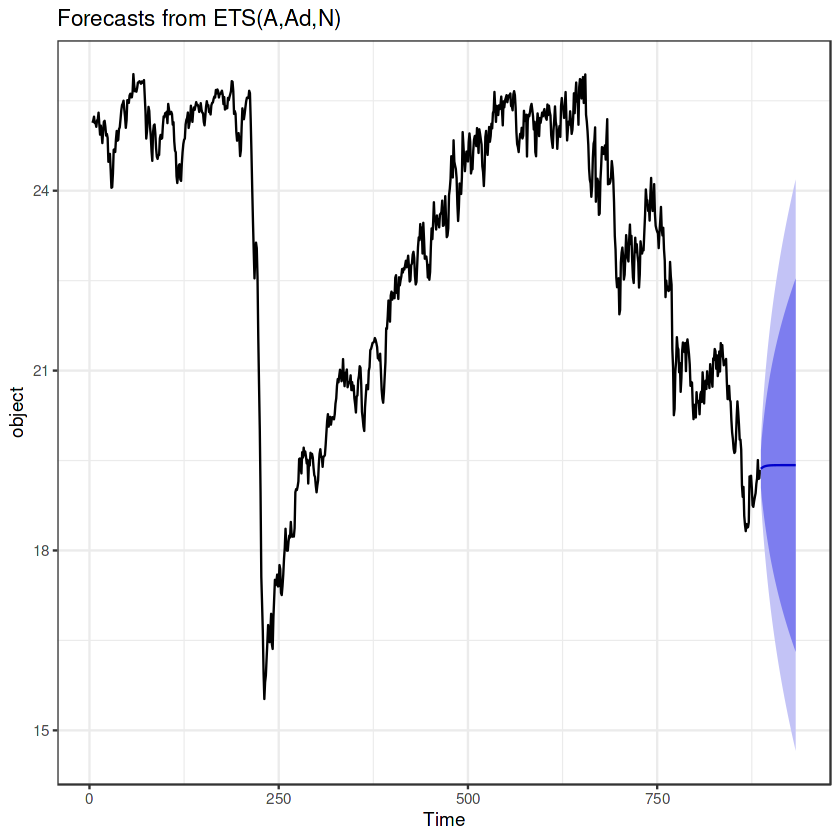

In [245]:
##Predicción del primer modelo sin tendencia:
pred2=stats::predict(mod1$fitted.values, h=47)
autoplot(predict(mod1$fitted.values, h=47))

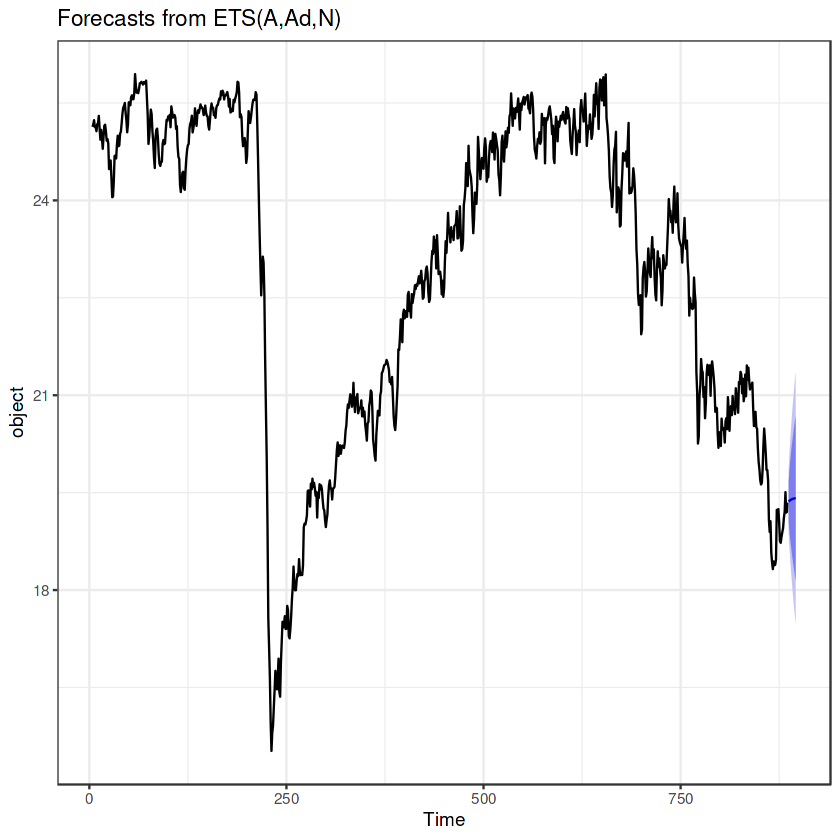

In [280]:
##Predicción del primer modelo sin tendencia:
pred0=stats::predict(mod1$fitted.values, h=10)
autoplot(predict(mod1$fitted.values, h=10))

In [273]:
pred3=as.ts(pred2['Point Forecast'])
class(pred3)

[1] "ts"

In [275]:
#Metricos de error Modelo ARDL
RMSE2<-rmse(data_test$RYLD,pred3)
RMSE2
MAE2<-mae(data_test$RYLD, pred3)
MAE2

[1] 0.3059226

[1] 0.2400017

#### Bound test

In [276]:
#Guardamos el mejor modelo obtenido en la sección anterior
modelo <- models$best_model
#Realizamos la prueba de hipotesis
bounds_f_test(modelo, case = 2) # el parametro "case" igual a 2 verifica si existe relaciones a largo termino, con la combinación de (restricted constant, no linear trend).



	Bounds F-test (Wald) for no cointegration

data:  d(RYLD) ~ L(RYLD, 1) + L(TSLA, 1) + L(TM, 1) + L(GM, 1) + d(L(RYLD,     1)) + d(L(RYLD, 2)) + d(TSLA) + d(TM) + d(GM) + d(L(GM, 1)) +     d(L(GM, 2))
F = 2.5919, p-value = 0.2228
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


In [277]:
#Realizamos la prueba de hipotesis para el modelo con tendencia
bounds_f_test(mod1_ten, case = 4) # el parametro "case" igual a 4 implica (unrestricted constant, linear trend)


	Bounds F-test (Wald) for no cointegration

data:  d(RYLD) ~ trend(RYLD) + L(RYLD, 1) + L(TSLA, 1) + L(TM, 1) +     L(GM, 1) + d(L(RYLD, 1)) + d(L(RYLD, 2)) + d(TSLA) + d(TM) +     d(GM) + d(L(GM, 1)) + d(L(GM, 2))
F = 2.3418, p-value = 0.4841
alternative hypothesis: Possible cointegration
null values:
   k    T 
   3 1000 


In [278]:
#Multiplicadores a corto plazo
multipliers(modelo, type = "sr")

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),0.148848875,0.0915043640,1.626686,1.041655e-01
2,TSLA,0.006235931,0.0008919174,6.991602,5.408892e-12
3,TM,0.027456034,0.0034882965,7.870900,1.043152e-14
4,GM,0.094434868,0.0074301356,12.709710,4.508574e-34


In [279]:
#Multiplicadores a largo plazo
multipliers(modelo)

,Term,Estimate,Std. Error,t value,Pr(>|t|)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),8.44514390,4.021866309,2.099807,0.0360329457
2,TSLA,-0.02177608,0.005783516,-3.765197,0.0001775872
3,TM,0.07034011,0.037839392,1.858912,0.0633766642
4,GM,0.17566844,0.054624276,3.215941,0.0013481119


*Elaborado por Rebeca Gamboa para el curso de Pronósticos, MIAD*